In [2]:
import pandas as pd
import json
import numpy as np
import re
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [5]:
all_data = []
for year in range(1991, 2020):
    with open(f'../data/year_data_{year}.json') as f:
        data = json.loads(f.read())
        for comp_cat in data:
            every_row = {
                'year': year,
                'title': comp_cat['title'],
                'date': comp_cat['date'],
                'comp_id': comp_cat['comp_id'],
                'cat_id': comp_cat['cat_id'],
                'type': comp_cat['type']
            }
            row_data = pd.DataFrame(list(map(lambda x: {**x, **every_row}, comp_cat['ranked_athletes'])))
            all_data.append(row_data)

df = pd.concat(all_data, ignore_index=True)
df.to_csv('../data/worldcup_data.csv')
df

,athlete_id,rank,year,title,date,comp_id,cat_id,type
0,266,1,1991,uiaa worldcup - wien 1991,26 April 1991,85,1,lead
1,849,2,1991,uiaa worldcup - wien 1991,26 April 1991,85,1,lead
2,461,3,1991,uiaa worldcup - wien 1991,26 April 1991,85,1,lead
3,973,4,1991,uiaa worldcup - wien 1991,26 April 1991,85,1,lead
4,678,5,1991,uiaa worldcup - wien 1991,26 April 1991,85,1,lead
...,...,...,...,...,...,...,...,...
38590,7994,47,2019,ifsc climbing worldcup (l) - inzai (jpn) 2019,26 - 27 Oktober 2019,7953,1,lead
38591,10059,51,2019,ifsc climbing worldcup (l) - inzai (jpn) 2019,26 - 27 Oktober 2019,7953,1,lead
38592,11380,52,2019,ifsc climbing worldcup (l) - inzai (jpn) 2019,26 - 27 Oktober 2019,7953,1,lead
38593,11470,53,2019,ifsc climbing worldcup (l) - inzai (jpn) 2019,26 - 27 Oktober 2019,7953,1,lead


In [92]:
dates = df['date'].copy()
years = dates.str[-4:]

pattern = re.compile(r'[^a-zA-Z]') # Grab only alpha chars
month_map = {'Februar':2,
             'Juli':7,
             'Dezember':12,
             'April':4,
             'Mrz':3,
             'September':9,
             'Juni':6,
             'Mai':5,
             'Oktober':10,
             'JuniMai':6,
             'August':8,
             'November':11,
             'Januar':1,
             'JuniJuli':6,
             'AugustSeptember':8,
             'SeptemberOktober':9,
             'MaiJuni':5,
             'JuliAugust':7,
             'MrzMai':3,
             'AprilMai':4,
             'OktoberNovember':10,
             'NovemberDezember':11,
             'DezemberNovember':11,
             'SeptemberAugust':8,
             'AugustJuli':7,
             'NovemberOktober':10,
             'FebruarJanuar':1,
             'MaiApril':4,
             'OktoberSeptember':9,
             'MrzApril':3} # unfortunately some of these when listing multiples months flip the order. Maybe something to watch for. Basically don't trust the days
months = dates.apply(lambda x: pattern.sub('', x))
months = months.apply(month_map.get)

def stop_at_alpha(text):
    non_alpha = ''
    for char in text:
        if char.isalpha():
            break
        non_alpha += char
    return non_alpha.strip().split('-')[0]
        
days = dates.apply(stop_at_alpha)
df['day'] = days.astype(int)
df['month'] = months.astype(int)
df['parsed_date'] = pd.to_datetime(df.year*10000+df.month*100+df.day,format='%Y%m%d')
df['year'] = pd.to_datetime(df.year,format='%Y')
df.to_csv('../data/clean_worldcup_data.csv')

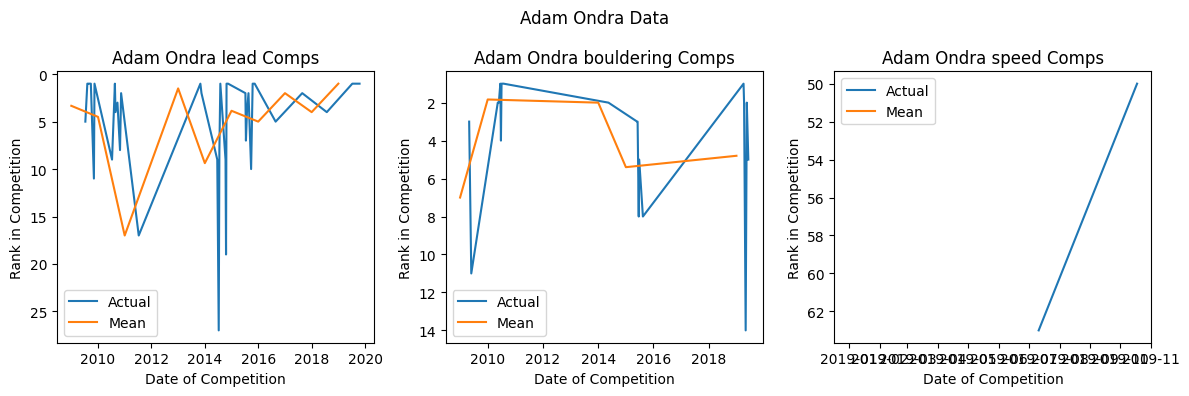

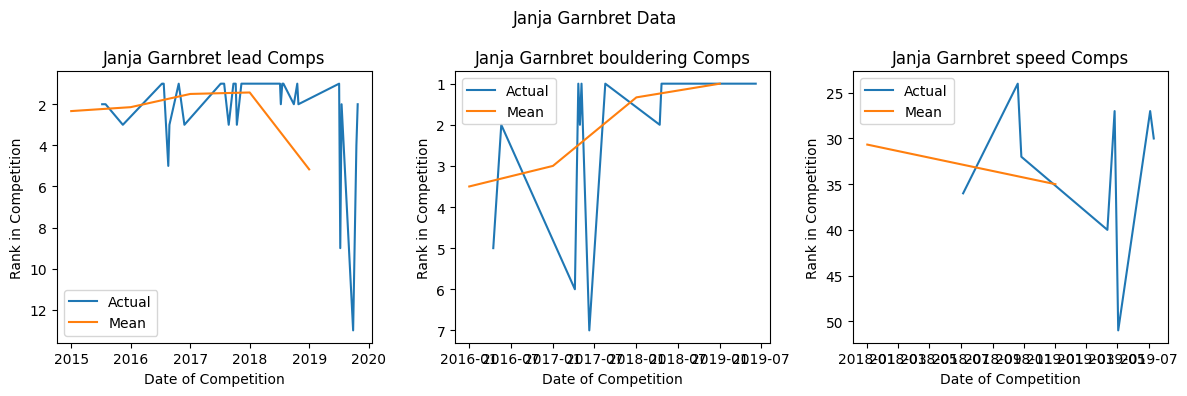

In [102]:
def plot_athlete(id_, name):
    def plot_type(type_):
        data = df[(df['athlete_id'] == id_) & (df['type'] == type_)]
        plt.plot(data['parsed_date'], data['rank'], label='Actual')
        grouped = data.groupby('year').mean()
        plt.plot(grouped.index, grouped['rank'], label='Mean')
        plt.gca().invert_yaxis()
        plt.legend()
        plt.ylabel('Rank in Competition')
        plt.xlabel('Date of Competition')
        plt.title(f'{name} {type_} Comps')
    
    old_figsize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [12, 4]
    
    plt.subplot(131)
    plot_type('lead')
    plt.subplot(132)
    plot_type('bouldering')
    plt.subplot(133)
    plot_type('speed')
    plt.suptitle(f'{name} Data')
    plt.tight_layout()
    plt.show()
    
    plt.rcParams['figure.figsize'] = old_figsize

plot_athlete(8372, 'Adam Ondra')
plot_athlete(11989, 'Janja Garnbret')

# plt.plot(df.groupby(['athlete_id', 'year'])['rank'].mean())
# df.groupby(['athlete_id', 'year'])['rank'].mean().plot(x='year')
# plt.gca().invert_yaxis()
# plt.show()